<h1> Import Dataset 

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data x: ' + str(x_train.shape))
print('Training Data y: ' + str(y_train.shape))
print('Test Data x: '  + str(x_test.shape))
print('Test Data y: '  + str(y_test.shape))

2022-04-07 22:42:46.633859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 22:42:46.633880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training Data x: (60000, 28, 28)
Training Data y: (60000,)
Test Data x: (10000, 28, 28)
Test Data y: (10000,)


<h1> Visualize Numbers of MNIST Dataset

3	5	1	

0	8	9	

0	9	1	



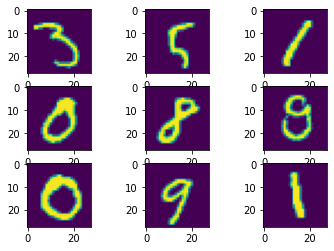

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors
import random

fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        temp = random.randint(1,100)
        array = x_train[temp]
        axs[i][j].imshow(array)
        print(y_train[temp],end="\t")
    print("\n")

<h1> Pre Processing Input Data 

In [3]:
from tensorflow.keras.utils import to_categorical

img_size = 28*28
x_train = x_train.reshape(x_train.shape[0], img_size)
x_test = x_test.reshape(x_test.shape[0], img_size)

num_classes = 10
y_oh_train = to_categorical(y_train, num_classes)
y_oh_test = to_categorical(y_test, num_classes)
print(f"{y_train[0]} is encoded as {y_oh_train[0]} in one hot encoded\n")
print('New Training Data x: ' + str(x_train.shape))
print('New Training Data y: ' + str(y_train.shape))
print('New Test Data x: '  + str(x_test.shape))
print('New Test Data y: '  + str(y_test.shape))



5 is encoded as [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] in one hot encoded

New Training Data x: (60000, 784)
New Training Data y: (60000,)
New Test Data x: (10000, 784)
New Test Data y: (10000,)


<h1> Feed Forward Neural Network

In [6]:
from tqdm.notebook import tqdm
import numpy as np

class FeedForwardNetwork:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

<h1> Train the Network

<p> The below neural network has 1 hidden layer of 32 nodes. Adding more hidden layers increases the accuracy at first by a little bit. But if too many layers are added test accuracy increases but validation accuracy decreases due to overfitting. Hence I have used only 1 hidden layer. Other parameters include number of epochs at 500 and learning rate alpha at 0.05.

  0%|          | 0/500 [00:00<?, ?epoch/s]

/tmp/ipykernel_3743/3211517791.py:16: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-x))


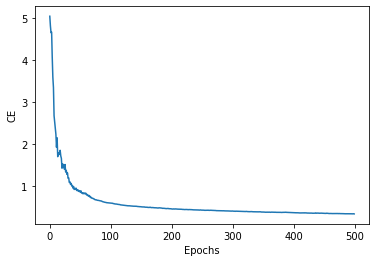

Training accuracy 0.9
Validation accuracy 0.89


In [7]:

from sklearn.metrics import accuracy_score


NeuralNetwork = FeedForwardNetwork(784,10,[32])
NeuralNetwork.fit(x_train,y_oh_train,epochs=500,learning_rate=.05,display_loss=True)

PredictedY_train = NeuralNetwork.predict(x_train)
PredictedY_train = np.argmax(PredictedY_train,1)

PredictedY_validation = NeuralNetwork.predict(x_test)
PredictedY_validation = np.argmax(PredictedY_validation,1)

Train_acc = accuracy_score(PredictedY_train, y_train)
Train_validation = accuracy_score(PredictedY_validation, y_test)

print("Training accuracy", round(Train_acc, 2))
print("Validation accuracy", round(Train_validation, 2))
